In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import scipy
viridis = cm.get_cmap('viridis', 100)

def get_switch_positions(x,cc_automaton):
    switch_positions = []
    switches = cc_automaton['switches']
    for sw in switches:
        sp = sw[0]
        switch_positions.append(sp[0]+x@sp[1:])
    #print(switch_positions)
    return switch_positions

def run_trajectory(cc_automaton,step,number_of_iterations,traj_color='b'):
    points = []
    x = cc_automaton['x']
    state = cc_automaton['state']
    variables = cc_automaton['variables']
    switches = cc_automaton['switches']
    division_planes = cc_automaton['division_planes']
    division_shift = cc_automaton['division_shift']
    current_direction = get_direction_from_state(cc_automaton)
    for i in range(number_of_iterations):
        points.append(x)
        switch_positions_before = get_switch_positions(x,cc_automaton)        
        isDivided = False
        division_switch_before = 1.0
        if state in division_planes:
            dp = division_planes[state][0]
            division_switch_before = dp[0]+x@dp[1:]
            #print('division_switch_before=',division_switch_before)
        x_new = x+current_direction*step
        if state in division_planes:      
            dp = division_planes[state][0]
            division_switch_after = dp[0]+x_new@dp[1:]
            #print('division_switch_after=',division_switch_after)
            if division_switch_before*division_switch_after<=0:
                isDivided = True
                if division_planes[state][1] is not None:
                    state = division_planes[state][1]
                    cc_automaton['state'] = state
                x_new = x + division_shift
                current_direction = get_direction_from_state(cc_automaton)
                plt.plot([x[0],x_new[0]],[x[1],x_new[1]],traj_color+'--')
                #print('Divided!')
        if not isDivided:
            switch_positions_after = get_switch_positions(x_new,cc_automaton)
            for i in range(len(switches)):
                if switch_positions_before[i]*switch_positions_after[i]<=0:
                    trig_num = switches[i][1]
                    l = list(state)
                    if type(trig_num) is list:
                        for t in trig_num:
                            l[t] = switches[i][2][state[t]]
                    else:
                        l[trig_num] = switches[i][2][state[trig_num]]
                    state = tuple(l)
                    cc_automaton['state'] = state
                    current_direction = get_direction_from_state(cc_automaton)
                    #print('Changed state: ',state,current_direction)
        x = x_new
        cc_automaton['x'] = x
        cc_automaton['state'] = state

    return np.array(points)

def get_direction_from_state(cc_automaton):
    state = cc_automaton['state']
    state_vectors = cc_automaton['state_vectors']
    direction_vector = np.array(state_vectors[state])
    direction_vector = direction_vector/np.linalg.norm(direction_vector)
    return direction_vector

def draw_hyperplane2D(swp,xmin,xmax,ymin,ymax,style,alpha=1.0,npoints=50,linewidth=5,markersize=1):
    
    if np.abs(swp[1])<1e-6:
        bx = - swp[0]/swp[2]    
        dx = xmax-xmin        
        xmin-=dx*0.5
        xmax+=dx*0.5
        xx = np.linspace(xmin,xmax,npoints)
        yy = bx-1e-6*xx
        plt.plot(xx,yy,style,alpha=alpha,linewidth=linewidth,markersize=markersize)        
        
    elif np.abs(swp[2])<1e-6:
        by = - swp[0]/swp[1]                
        dy = ymax-ymin        
        ymin-=dy*0.5
        ymax+=dy*0.5
        yy = np.linspace(ymin,ymax,npoints)
        xx = by+1e-6*yy
        plt.plot(xx,yy,style,alpha=alpha,linewidth=linewidth,markersize=markersize)
    else:
        by = - swp[0]/swp[1]
        ay = - swp[2]/swp[1]

        dx = xmax-xmin
        dy = ymax-ymin
        xmin-=dx*0.5
        xmax+=dx*0.5
        ymin-=dy*0.5
        ymax+=dy*0.5

        yy = np.linspace(ymin,ymax,npoints)
        xx = by+ay*yy
        plt.plot(xx,yy,style,alpha=alpha,linewidth=linewidth,markersize=markersize)
        if xmin>np.min(xx):
            xmin = np.min(xx)
        if xmax>np.max(xx):  
            xmax = np.max(xx)

        bx = - swp[0]/swp[2]
        ax = - swp[1]/swp[2]
        xx = np.linspace(xmin,xmax,npoints)
        yy = bx+ax*xx
        
        plt.plot(xx,yy,style,alpha=alpha,linewidth=linewidth,markersize=markersize)

def _make_G1SG2M_plot(adata, egr, n_components=30, delta=0.05, subsample=None,highlighted_nodes=None,draw_principal_curve=False,alpha=0.5):
    fig = plt.figure(figsize=(5,5))
    plt.rcParams.update({'font.size': 12})
    X = adata.X

    X = adata.X
    X_prolif = adata.X[np.where(adata.obs['proliferating']==1)[0],:]
    mn_prolif = np.mean(X_prolif,axis=0)    
    
    pca = PCA(n_components=n_components)
    u = pca.fit_transform(X_prolif)
    v = pca.components_.T
    
    mn = mn_prolif
    
    tc_name = 'total_counts_raw'
    if not tc_name in adata.obs:
        tc_name = 'total_counts'
    tc = adata.obs[tc_name]
    tc = scipy.stats.mstats.winsorize(tc,limits=[0.1,0.1])
    tc = (tc-np.min(tc))/(np.max(tc)-np.min(tc))*100
    velocity_X = adata.layers['velocity']

    X1 = X + velocity_X*delta*1
    X2 = np.concatenate((X,X1),axis=0)
    adata_temp = anndata.AnnData(X = X2)
    adata_temp.obs_names = list(adata.obs_names)*2
    adata_temp.var_names = adata.var_names
    adata_temp.obs['total_counts'] = list(adata.obs['total_counts'])*2

    sc.pp.highly_variable_genes(adata_temp,n_top_genes=2001,n_bins=20)
    ind_genes2k = np.where(adata_temp.var['highly_variable'])[0]
    adata2k = adata_temp[:,ind_genes2k]
    signature_dict = {'S-phase':adata.uns['S-phase_genes'],'G2-M':adata.uns['G2-M_genes']}
    scores_dic = calc_scores(adata_temp,signature_dict)
    for s in scores_dic:
        adata_temp.obs[s] = scores_dic[s]

    n = X.shape[0]

    x1 = adata_temp.obs[['S-phase','G2-M']].to_numpy()[0:n]
    #print(x1.shape)
    x2 = adata_temp.obs[['S-phase','G2-M']].to_numpy()[n:2*n]

    nodep = egr[0]['NodePositions']
    edges = egr[0]['Edges'][0]
    
    n_nodes = nodep.shape[0]
    nodes_projection = np.zeros((n_nodes,2))
    node_real_coordinates = nodep@v.T+mn

    adata_nodes = anndata.AnnData(X = node_real_coordinates)
    adata_nodes.var_names = adata.var_names
    scores_dic_nodes = calc_scores(adata_nodes,signature_dict)
    for s in scores_dic_nodes:
        adata_nodes.obs[s] = scores_dic_nodes[s]

    #for i in range(n_nodes):
    #    nodes_projection[i,:] = np.mean(x1[np.where(partition==i)[0],:],axis=0)

    #cc.pp.score_cell_cycle(adata_temp)
    ax = fig.add_subplot(1,1,1)
    if subsample is None:
        subsample = range(n)
    ax.scatter(x1[subsample,0],x1[subsample,1],c=adata.obs['total_counts'][subsample],s=0.1)

    #plt.scatter(x1[:,0],x1[:,1],c='k',s=1)
    #plt.scatter(x2[:,0],x2[:,1],c='b',s=1)

    for i in subsample:
        p1 = x1[i,:]
        p2 = x2[i,:]-x1[i,:]
        if adata.obs['proliferating'][i]:
            plt.arrow(p1[0],p1[1],p2[0],p2[1],width=0.003,color=viridis(int(tc[i])),edgecolor=None,alpha=alpha)
        else:
            plt.arrow(p1[0],p1[1],p2[0],p2[1],width=0.003,color='grey',edgecolor=None,alpha=alpha)
        #plt.plot([p1[0],p2[0]],[p1[1],p2[1]],'k-')
    plt.xlabel('S-phase score',fontsize=15)
    plt.ylabel('G2-M score',fontsize=15)
    node_scores = adata_nodes.obs[['S-phase','G2-M']].to_numpy()
    if draw_principal_curve:
        for e in edges:
            #plt.plot([nodes_projection[e[0],0],nodes_projection[e[1],0]],
            #         [nodes_projection[e[0],1],nodes_projection[e[1],1]],'b-',linewidth=10)
            plt.plot([node_scores[e[0],0],node_scores[e[1],0]],
                     [node_scores[e[0],1],node_scores[e[1],1]],'r-',linewidth=3,alpha=0.5)
        if highlighted_nodes is not None:
            for k in highlighted_nodes:
                plt.plot(node_scores[k,0],node_scores[k,1],'ro',markersize=15,alpha=0.5)
            
    return node_scores, x1
    #plt.axis('equal')
    #plt.axis('off')
    #plt.axis(fontsize=20)
    #ax.xaxis.get_major_ticks().label.set_fontsize(20) 
    #plt.savefig(dataset_name+'_G1S_G2M.png')
    #plt.show()    
    
def calc_scores(anndata,signature_dict):
    matrix = anndata.to_df().to_numpy()
    scores_dic = {}
    for key in signature_dict:
        names = np.array(signature_dict[key])
        inds = np.where(np.isin(anndata.var_names,names))[0]
        matrix_sel = matrix[:,inds]
        scores = np.mean(matrix_sel,axis=1)
        scores_dic[key] = scores
    return scores_dic

def partition_data_based_on_lines(traj_vertices,X):
    line_vectors = []
    partition = np.zeros(X.shape[0])
    Xproj = np.zeros([X.shape[0],X.shape[1]])
    for k in range(1,len(traj_vertices)):
        line_vectors.append(traj_vertices[k]-traj_vertices[k-1])
    #print(line_vectors)
    dists = np.zeros(len(line_vectors))
    mse = 0
    for i in range(X.shape[0]):
        pvs = np.zeros([len(line_vectors),X.shape[1]])
        for j,v in enumerate(line_vectors):
            pvs[j],dists[j] = project_on_linesegment(X[i,:],traj_vertices[j],v)
        irx_min = np.argmin(dists)
        mse += np.min(dists)**2
        partition[i] = irx_min
        Xproj[i,:] = pvs[irx_min]
    return partition, Xproj, mse/X.shape[0]
        
def project_on_linesegment(x,start,vector):
    n = vector/np.linalg.norm(vector)
    proj_vec = start+(n@(x-start))*n
    if n@(x-start)<0:
        proj_vec = start
    elif np.linalg.norm(proj_vec-start)>np.linalg.norm(vector):
        proj_vec = start+vector
    #proj_vec = start    
    dist = np.linalg.norm(x-proj_vec)
    return proj_vec, dist

def optimize_vertex(traj_vertices,X,vertex_to_optimze):
    partition, Xproj, mse = partition_data_based_on_lines(traj_vertices,X)
    irx_subset1 = np.where(partition==vertex_to_optimze-1)[0]
    irx_subset2 = np.where(partition==vertex_to_optimze)[0]
    pca = PCA(n_components=1)
    m1 = np.mean(X[irx_subset1,:],axis=0)
    #print('m1',m1)
    pca.fit(X[irx_subset1,:])
    v1 = pca.components_[0]
    pca = PCA(n_components=1)
    pca.fit(X[irx_subset2,:])
    m2 = np.mean(X[irx_subset2,:],axis=0)
    v2 = pca.components_[0]
    #print('v1=',v1)
    #print('v2=',v2)
    new_pos = intersection_lines_2D(m1,m1+v1,m2,m2+v2)
    #plt.plot([m1[0],m1[0]+v1[0]],[m1[1],m1[1]+v1[1]],'r-',linewidth=3)
    #plt.plot([m2[0],m2[0]+v2[0]],[m2[1],m2[1]+v2[1]],'r-',linewidth=3)
    return new_pos

def intersection_lines_2D(p1,p2,p3,p4):
    x1 = p1[0]
    y1 = p1[1]
    x2 = p2[0]
    y2 = p2[1]
    x3 = p3[0]
    y3 = p3[1]
    x4 = p4[0]
    y4 = p4[1]    
    d = (x1-x2)*(y3-y4)-(y1-y2)*(x3-x4)
    kx = ((x1*y2-y1*x2)*(x3-x4)-(x1-x2)*(x3*y4-y3*x4))/d
    ky = ((x1*y2-y1*x2)*(y3-y4)-(y1-y2)*(x3*y4-y3*x4))/d
    return np.array([kx,ky])

def define_SG2M_model_2D(cmin,smax,mmax,me,state_vectors):
    variables = ['s','m']
    division_planes = {(1,1):([-me,0.0,1.0],(0,0))}
    division_shift = np.array([-np.log10(2)]*len(variables))
    switches = [([-cmin,0.0,1.0],[0,1],{0:2,1:2,2:2}),
                ([-smax,1.0,0.0],0,{0:1,1:1,2:1}),
                ([-mmax,0.0,1.0],[0,1],{0:1,1:1,2:1})]
    cc_automaton = {'variables':variables,
                    'state_vectors':state_vectors,
                    'division_planes': division_planes,
                    'division_shift':division_shift,
                    'switches':switches}
    return cc_automaton

def simulate_the_model_2D(cc_automaton,x0,initial_state,num_iterations=10000,step=0.01,division_color='c'):
    plt.plot(x0[0],x0[1],'ko')
    points = run_trajectory(cc_automaton,step,num_iterations,traj_color=division_color)
    plt.scatter(points[:,0],points[:,1],c='b',alpha=0.03)
    plt.axis('equal')
    xmin = np.min(points,axis=0)[0]
    xmax = np.max(points,axis=0)[0]
    ymin = np.min(points,axis=0)[1]
    ymax = np.max(points,axis=0)[1]
    for sw in cc_automaton['switches']:
        draw_hyperplane2D(sw[0],xmin,xmax,ymin,ymax,'k.-',alpha=0.5,npoints=100,linewidth=1,markersize=1)
        #draw_hyperplane2D(sw[0],xmin,xmax,ymin,ymax,'k.',alpha=0.3,npoints=50)
        #draw_hyperplane2D(sw[0],xmin,xmax,ymin,ymax,'k.',alpha=0.3,npoints=50)
    division_planes = cc_automaton['division_planes']
    for dpk in division_planes.keys():    
        dp = division_planes[dpk][0].copy()
        draw_hyperplane2D(dp,xmin,xmax,ymin,ymax,'m-',linewidth=2,markersize=1)
        dp_birth = dp.copy()
        dp_birth[0] = dp[0]-dp[1]*division_shift[0]-dp[2]*division_shift[1]
        draw_hyperplane2D(dp_birth,xmin,xmax,ymin,ymax,'m--',linewidth=2,markersize=1)
    extend_factor = 0.1
    plt.xlim([xmin-(xmax-xmin)*extend_factor,xmax+(xmax-xmin)*extend_factor])
    plt.ylim([ymin-(ymax-ymin)*extend_factor,ymax+(ymax-ymin)*extend_factor])
    return points

# Part I. Playing with a toy model with a single trigger

<Figure size 360x360 with 0 Axes>

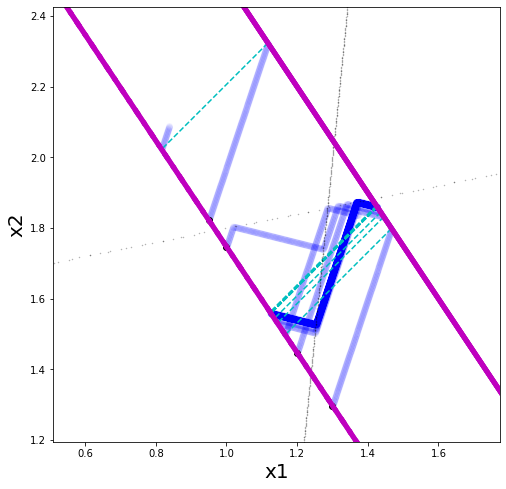

In [5]:
# Toy example of one single trigger

plt.figure(figsize=(5,5))

variables = ['x1','x2']


# format of hyperplanes, n+1 values : shift value + normal vector
# format of division planes: dictionary of states, value = tuple(division_hyperplane,state_after_division)
# format of switches, tuple, 
# first: switch hyperplane, 
# second : which trigger is affected, 
# third, map between trigger states (before switch:after switch)

# single stable limiting cycle
state_vectors = {(0,):[0.8,-0.2],(1,):[0.2,0.6]}
division_planes = {(1,):([-4,1.5,1.0],None),
                   (0,):([-4,1.5,1.0],(0,))}
switches = [([-1.1,+1.0,-0.1],0,{0:1,1:1}),
            ([-0.8,-0.1,+0.5],0,{0:0,1:0})]
initial_state = (1,)

division_shift = np.array([-np.log10(2)]*len(variables))
dp = division_planes[(0,)][0].copy()
dp_birth = dp.copy()
dp_birth[0] = dp[0]-dp[1]*division_shift[0]-dp[2]*division_shift[1]

step = 0.001
cc_automaton = {'variables':variables,
                'state_vectors':state_vectors,
                'division_planes': division_planes,
                'division_shift':division_shift,
                'switches':switches}


plt.figure(figsize=(8,8))

x0_pos = 0.95
x0 = np.array([x0_pos,-dp_birth[0]/dp_birth[2]-x0_pos*dp_birth[1]/dp_birth[2]])
cc_automaton['x'] = x0
cc_automaton['state'] = initial_state
plt.plot(x0[0],x0[1],'ko')
points1 = run_trajectory(cc_automaton,step,600,traj_color='c')

x0_pos = 1.0
x0 = np.array([x0_pos,-dp_birth[0]/dp_birth[2]-x0_pos*dp_birth[1]/dp_birth[2]])
cc_automaton['x'] = x0
cc_automaton['state'] = initial_state
plt.plot(x0[0],x0[1],'ko')
points2 = run_trajectory(cc_automaton,step,10000,traj_color='c')

x0_pos = 1.2
x0 = np.array([x0_pos,-dp_birth[0]/dp_birth[2]-x0_pos*dp_birth[1]/dp_birth[2]])
cc_automaton['x'] = x0
cc_automaton['state'] = initial_state
plt.plot(x0[0],x0[1],'ko')
points3 = run_trajectory(cc_automaton,step,1000,traj_color='c')

x0_pos = 1.3
x0 = np.array([x0_pos,-dp_birth[0]/dp_birth[2]-x0_pos*dp_birth[1]/dp_birth[2]])
cc_automaton['x'] = x0
cc_automaton['state'] = initial_state
plt.plot(x0[0],x0[1],'ko')
points4 = run_trajectory(cc_automaton,step,1000,traj_color='c')

points = np.concatenate([points1,points2,points3,points4],axis=0)

plt.scatter(points[:,0],points[:,1],c='b',alpha=0.02)
plt.axis('equal')
#plt.plot(cc_automaton['x'][0],cc_automaton['x'][1],'mo',markersize=10)

xmin = np.min(points,axis=0)[0]
xmax = np.max(points,axis=0)[0]
ymin = np.min(points,axis=0)[1]
ymax = np.max(points,axis=0)[1]

#for sw in switches:
draw_hyperplane2D(switches[0][0],xmin,xmax,ymin,ymax,'k.',alpha=0.3,npoints=500)
draw_hyperplane2D(switches[1][0],xmin,xmax,ymin,ymax,'k.',alpha=0.3,npoints=200)
    
for dpk in division_planes.keys():    
    dp = division_planes[dpk][0].copy()
    draw_hyperplane2D(dp,xmin,xmax,ymin,ymax,'m-')
    dp_birth = dp.copy()
    dp_birth[0] = dp[0]-dp[1]*division_shift[0]-dp[2]*division_shift[1]
    draw_hyperplane2D(dp_birth,xmin,xmax,ymin,ymax,'m--')


plt.xlabel(cc_automaton['variables'][0],fontsize=20)    
plt.ylabel(cc_automaton['variables'][1],fontsize=20)    
extend_factor = 0.1
plt.xlim([xmin-(xmax-xmin)*extend_factor,xmax+(xmax-xmin)*extend_factor])
plt.ylim([ymin-(ymax-ymin)*extend_factor,ymax+(ymax-ymin)*extend_factor])
plt.show()




<Figure size 360x360 with 0 Axes>

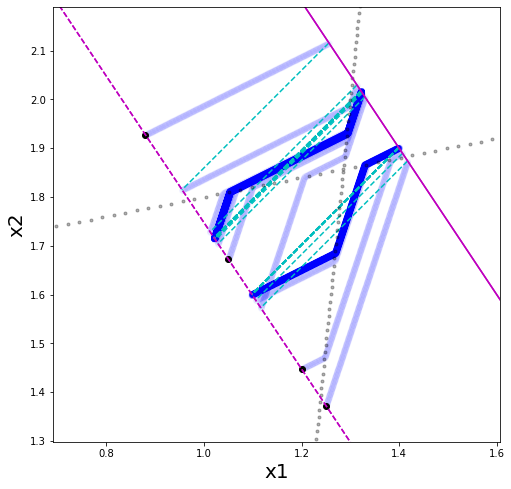

In [17]:
# Toy example of one single trigger

plt.figure(figsize=(5,5))

# Two limiting cycles
state_vectors = {(0,):[0.8,0.4],(1,):[0.2,0.6]}
division_planes = {(1,):([-4,1.5,1.0],None),
                   (0,):([-4,1.5,1.0],(0,))}
switches = [([-1.1,+1.0,-0.1],0,{0:1,1:1}),
            ([-0.8,-0.1,+0.5],0,{0:0,1:0})]
initial_state = (0,)

division_shift = np.array([-np.log10(2)]*len(variables))
dp_birth = dp.copy()
dp_birth[0] = dp[0]-dp[1]*division_shift[0]-dp[2]*division_shift[1]

step = 0.001
cc_automaton = {'variables':variables,
                'state_vectors':state_vectors,
                'division_planes': division_planes,
                'division_shift':division_shift,
                'switches':switches}


plt.figure(figsize=(8,8))

x0_pos = 0.88
initial_state = (0,)
x0 = np.array([x0_pos,-dp_birth[0]/dp_birth[2]-x0_pos*dp_birth[1]/dp_birth[2]])
cc_automaton['x'] = x0
cc_automaton['state'] = initial_state
plt.plot(x0[0],x0[1],'ko')
points1 = run_trajectory(cc_automaton,step,10000,traj_color='c')

x0_pos = 1.25
initial_state = (1,)
x0 = np.array([x0_pos,-dp_birth[0]/dp_birth[2]-x0_pos*dp_birth[1]/dp_birth[2]])
cc_automaton['x'] = x0
cc_automaton['state'] = initial_state
plt.plot(x0[0],x0[1],'ko')
points2 = run_trajectory(cc_automaton,step,10000,traj_color='c')


x0_pos = 1.05
initial_state = (1,)
x0 = np.array([x0_pos,-dp_birth[0]/dp_birth[2]-x0_pos*dp_birth[1]/dp_birth[2]])
cc_automaton['x'] = x0
cc_automaton['state'] = initial_state
plt.plot(x0[0],x0[1],'ko')
points3 = run_trajectory(cc_automaton,step,10000,traj_color='c')

x0_pos = 1.2
initial_state = (0,)
x0 = np.array([x0_pos,-dp_birth[0]/dp_birth[2]-x0_pos*dp_birth[1]/dp_birth[2]])
cc_automaton['x'] = x0
cc_automaton['state'] = initial_state
plt.plot(x0[0],x0[1],'ko')
points4 = run_trajectory(cc_automaton,step,10000,traj_color='c')

points = np.concatenate([points1,points2,points3,points4],axis=0)
#points = np.concatenate([points1,points2],axis=0)

plt.scatter(points[:,0],points[:,1],c='b',alpha=0.02)
plt.axis('equal')
#plt.plot(cc_automaton['x'][0],cc_automaton['x'][1],'mo',markersize=10)

xmin = np.min(points,axis=0)[0]
xmax = np.max(points,axis=0)[0]
ymin = np.min(points,axis=0)[1]
ymax = np.max(points,axis=0)[1]

#for sw in switches:
draw_hyperplane2D(switches[0][0],xmin,xmax,ymin,ymax,'k.',alpha=0.3,npoints=500)
draw_hyperplane2D(switches[1][0],xmin,xmax,ymin,ymax,'k.',alpha=0.3,npoints=200)
    
for dpk in division_planes.keys():    
    dp = division_planes[dpk][0].copy()
    draw_hyperplane2D(dp,xmin,xmax,ymin,ymax,'m-')
    dp_birth = dp.copy()
    dp_birth[0] = dp[0]-dp[1]*division_shift[0]-dp[2]*division_shift[1]
    draw_hyperplane2D(dp_birth,xmin,xmax,ymin,ymax,'m--')


plt.xlabel(cc_automaton['variables'][0],fontsize=20)    
plt.ylabel(cc_automaton['variables'][1],fontsize=20)    
extend_factor = 0.1
plt.xlim([xmin-(xmax-xmin)*extend_factor,xmax+(xmax-xmin)*extend_factor])
plt.ylim([ymin-(ymax-ymin)*extend_factor,ymax+(ymax-ymin)*extend_factor])
plt.show()




<Figure size 360x360 with 0 Axes>

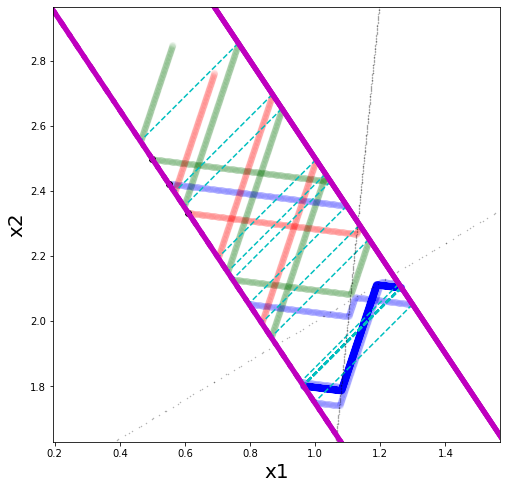

In [6]:
# Toy example of one single trigger

plt.figure(figsize=(5,5))


# Complex dependence on initial conditions
state_vectors = {(0,):[0.8,-0.1],(1,):[0.2,0.6]}
division_planes = {(1,):([-4,1.5,1.0],None),
                   (0,):([-4,1.5,1.0],(0,))}
switches = [([-0.9,+1.0,-0.1],0,{0:1,1:1}),
            ([-0.7,-0.3,+0.5],0,{0:0,1:0})]
initial_state = (0,)

division_shift = np.array([-np.log10(2)]*len(variables))
dp_birth = dp.copy()
dp_birth[0] = dp[0]-dp[1]*division_shift[0]-dp[2]*division_shift[1]

step = 0.001
cc_automaton = {'variables':variables,
                'state_vectors':state_vectors,
                'division_planes': division_planes,
                'division_shift':division_shift,
                'switches':switches}


plt.figure(figsize=(8,8))

x0_pos = 0.5
initial_state = (0,)
x0 = np.array([x0_pos,-dp_birth[0]/dp_birth[2]-x0_pos*dp_birth[1]/dp_birth[2]])
cc_automaton['x'] = x0
cc_automaton['state'] = initial_state
plt.plot(x0[0],x0[1],'ko')
points1 = run_trajectory(cc_automaton,step,3000,traj_color='c')

x0_pos = 0.55
initial_state = (0,)
x0 = np.array([x0_pos,-dp_birth[0]/dp_birth[2]-x0_pos*dp_birth[1]/dp_birth[2]])
cc_automaton['x'] = x0
cc_automaton['state'] = initial_state
plt.plot(x0[0],x0[1],'ko')
points2 = run_trajectory(cc_automaton,step,10000,traj_color='c')

x0_pos = 0.61
initial_state = (0,)
x0 = np.array([x0_pos,-dp_birth[0]/dp_birth[2]-x0_pos*dp_birth[1]/dp_birth[2]])
cc_automaton['x'] = x0
cc_automaton['state'] = initial_state
plt.plot(x0[0],x0[1],'ko')
points3 = run_trajectory(cc_automaton,step,2000,traj_color='c')

#points = np.concatenate([points0,points1,points2,points3,points4],axis=0)
points = np.concatenate([points1,points2,points3],axis=0)
#points = points4

plt.scatter(points1[:,0],points1[:,1],c='g',alpha=0.02)
plt.scatter(points2[:,0],points2[:,1],c='b',alpha=0.02)
plt.scatter(points3[:,0],points3[:,1],c='r',alpha=0.02)
plt.axis('equal')
#plt.plot(cc_automaton['x'][0],cc_automaton['x'][1],'mo',markersize=10)

xmin = np.min(points,axis=0)[0]
xmax = np.max(points,axis=0)[0]
ymin = np.min(points,axis=0)[1]
ymax = np.max(points,axis=0)[1]

#for sw in switches:
draw_hyperplane2D(switches[0][0],xmin,xmax,ymin,ymax,'k.',alpha=0.3,npoints=500)
draw_hyperplane2D(switches[1][0],xmin,xmax,ymin,ymax,'k.',alpha=0.3,npoints=100)
    
for dpk in division_planes.keys():    
    dp = division_planes[dpk][0].copy()
    draw_hyperplane2D(dp,xmin,xmax,ymin,ymax,'m-')
    dp_birth = dp.copy()
    dp_birth[0] = dp[0]-dp[1]*division_shift[0]-dp[2]*division_shift[1]
    draw_hyperplane2D(dp_birth,xmin,xmax,ymin,ymax,'m--')


plt.xlabel(cc_automaton['variables'][0],fontsize=20)    
plt.ylabel(cc_automaton['variables'][1],fontsize=20)    
extend_factor = 0.1
plt.xlim([xmin-(xmax-xmin)*extend_factor,xmax+(xmax-xmin)*extend_factor])
plt.ylim([ymin-(ymax-ymin)*extend_factor,ymax+(ymax-ymin)*extend_factor])
plt.show()




# Part II. Fitting the real transcriptomic trajectory (in S- and G2/M-phase scores coordinates)

In [7]:
# Loading the data

import sys
sys.path.append('/home/zinovyev/anaconda3/lib/python3.7/site-packages')
import anndata
import scanpy as sc

dataset_name = 'CHLA9'
folder = '/mnt/c/Datas/SingleCellTranscriptomics/RNAVelocity/'
adata = sc.read_h5ad(folder+dataset_name+'_renorm_proc.h5ad')

/home/zinovyev/.local/lib/python3.7/site-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [1]:
# defining the model parameters

import scipy

plt.rcParams['figure.dpi'] = 200

curvature_peaks = adata.uns['CurvaturePeaks']
nodep = adata.uns['ElasticGraph_nodes']
traj = adata.uns['Trajectory']

subsample_size = 1500
idx_subsample = np.random.choice(range(len(adata)),subsample_size,replace=False)

egr_final = {}
egr_final['NodePositions'] = adata.uns['ElasticGraph_nodes']
egr_final['Edges'] = tuple(adata.uns['ElasticGraph_edges'])


node_scores, X = _make_G1SG2M_plot(adata,[egr_final],subsample=idx_subsample,draw_principal_curve=False,alpha=1.0)
#plt.plot(X[idx_subsample,0],X[idx_subsample,1],'k.',alpha=0.3,color='grey')
X_nonprolif = X[adata.obs['proliferating']==0,:]
x_f = node_scores[traj[len(traj)-1],:]
x_0 = x_f - np.array([np.log10(2),np.log10(2)])
#irx_nonprolif = np.argmax(np.sum(X_nonprolif,axis=1))
x_B = node_scores[traj[curvature_peaks[1]],:]
x_C = node_scores[traj[curvature_peaks[2]],:]
x_D = node_scores[traj[curvature_peaks[3]],:]

x_bprime = np.median(X_nonprolif,axis=0)
#x_bprime = x_B

#x_C = [1.6,0.9]
#print(x_C)

traj_vertices = [x_0,x_bprime,x_C,x_D,x_f]
seq_vert = [1,2]
for it in range(10):
    for v in seq_vert:
        new_pos = optimize_vertex(traj_vertices,X,v)
        mse_old = mse
        partition, Xproj, mse = partition_data_based_on_lines(traj_vertices,X)
        if np.abs(mse-mse_old)/(mse+mse_old)<1e-4:
            break
        print('mse=',mse)        
        traj_vertices[v] = new_pos
x_bprime = traj_vertices[1]
x_C = traj_vertices[2]

cmin = x_bprime[0]+x_bprime[1]
cmin = x_bprime[1]
#cmin = cmin*2
smax = x_C[0]
mmax = x_D[1]
me = x_f[1]

state_vectors_temp = {}
state_vectors_temp[(0,0)] = [x_bprime[0]-x_0[0],x_bprime[1]-x_0[1]]
state_vectors_temp[(2,2)] = [x_C[0]-x_bprime[0],x_C[1]-x_bprime[1]]
state_vectors_temp[(1,2)] = [x_D[0]-x_C[0],x_D[1]-x_C[1]]
state_vectors_temp[(1,1)] = [x_f[0]-x_D[0],x_f[1]-x_D[1]]
for st in state_vectors_temp.keys():
    state_vectors_temp[st] /=np.linalg.norm(state_vectors_temp[st]) 

k_s_2 = state_vectors_temp[(2,2)][0]
k_m_2 = state_vectors_temp[(2,2)][1]

state_vectors_temp[(1,2)] = state_vectors_temp[(1,2)]*k_m_2/state_vectors_temp[(1,2)][1]
k_s_1 = state_vectors_temp[(1,2)][0]*k_m_2/state_vectors_temp[(1,2)][1]
state_vectors_temp[(1,1)] = state_vectors_temp[(1,1)]*k_s_1/state_vectors_temp[(1,1)][0]
k_m_1 = state_vectors_temp[(1,1)][1]

k_s_0 = state_vectors_temp[(0,0)][0]
k_m_0 = state_vectors_temp[(0,0)][1]


rates = {'s':[k_s_0,k_s_1,k_s_2],
        'm':[k_m_0,k_m_1,k_m_2]}

initial_state = (0,0)
step = 0.01

trigger_state_names = ['elimination','decay','synthesis']
state_vectors = {}
for i in range(3):
    for j in range(3):
        state_vectors[(i,j)] = [rates['s'][i],rates['m'][j]]
#        state_vectors[(i,j)] /=np.linalg.norm(state_vectors[(i,j)])
        
print(state_vectors)

cc_automaton = define_SG2M_model_2D(cmin=cmin,smax=smax,mmax=mmax,me=me,state_vectors=state_vectors)

cc_automaton['x'] = x_0
cc_automaton['state'] = initial_state

points = simulate_the_model_2D(cc_automaton,x0=x_0,initial_state=initial_state)

plt.plot(points[:,0],points[:,1],'b.',markersize=5,linewidth=5,alpha=0.1)
markersize = 10
plt.plot(x_0[0],x_0[1],'ro',markersize=markersize,alpha=0.5)
plt.plot(x_f[0],x_f[1],'ro',markersize=markersize,alpha=0.5)
plt.plot(x_bprime[0],x_bprime[1],'ro',markersize=markersize,alpha=0.5)
plt.plot(x_C[0],x_C[1],'ro',markersize=markersize,alpha=0.5)
plt.plot(x_D[0],x_D[1],'ro',markersize=markersize,alpha=0.5)


plt.savefig(dataset_name+'_switch_linear.png',dpi=600)

plt.show()

NameError: name 'plt' is not defined

(-1.0, 8.0)

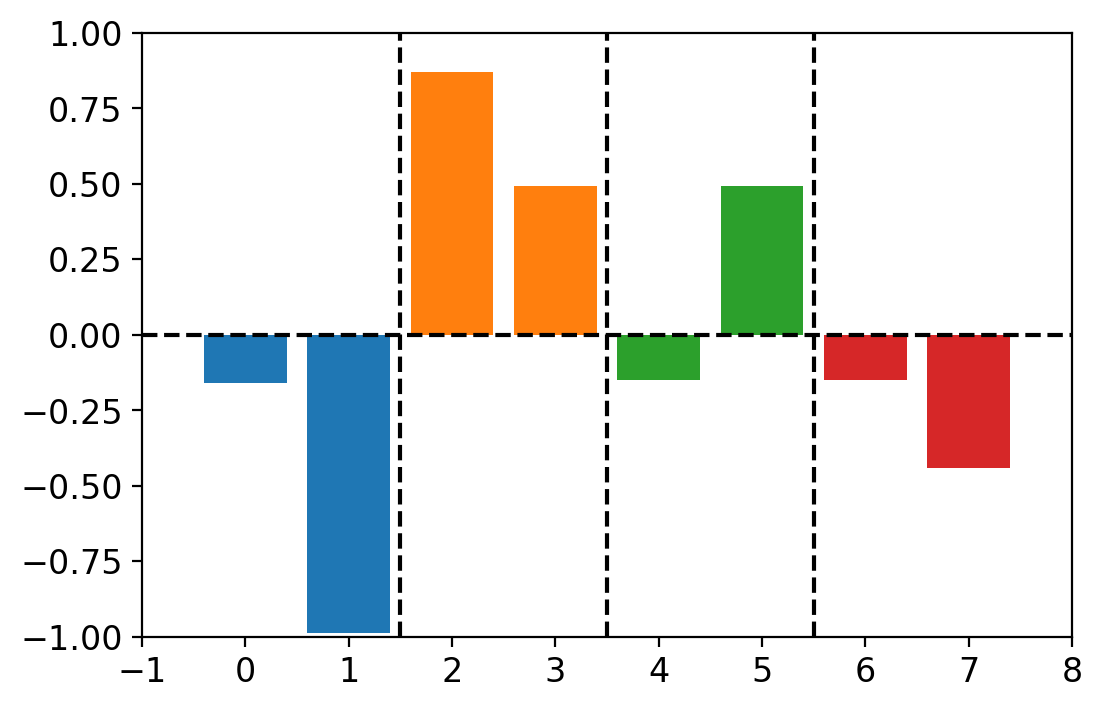

In [355]:
# Plotting the parameter values (rates)

plt.bar([0,1],state_vectors[(0,0)])
plt.bar([2,3],state_vectors[(2,2)])
plt.bar([4,5],state_vectors[(1,2)])
plt.bar([6,7],state_vectors[(1,1)])
plt.plot([1.5,1.5],[-1,1],'k--')
plt.plot([3.5,3.5],[-1,1],'k--')
plt.plot([5.5,5.5],[-1,1],'k--')
plt.plot([-1,8],[0,0],'k--')
plt.ylim([-1,1])
plt.xlim([-1,8])

mse= 0.007594111958364033
mse= 0.00674611714242852
mse= 0.005259304206200788
mse= 0.005135695658261309
mse= 0.004997585516100875
mse= 0.00494676899778288
mse= 0.00493177095372213
mse= 0.004923250070915213
mse= 0.0049229860218387425


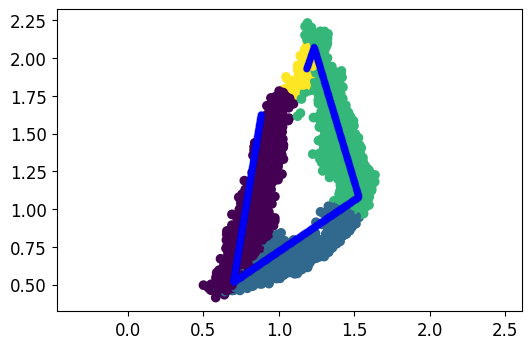

In [320]:
# Improving the position of the turning point, to make the data approximation better

traj_vertices = [x_0,x_bprime,x_C,x_D,x_f]

seq_vert = [1,2]
for it in range(10):
    for v in seq_vert:
        new_pos = optimize_vertex(traj_vertices,X,v)
        mse_old = mse
        partition, Xproj, mse = partition_data_based_on_lines(traj_vertices,X)
        if np.abs(mse-mse_old)/(mse+mse_old)<1e-4:
            break
        print('mse=',mse)        
        traj_vertices[v] = new_pos

partition, Xproj, mse = partition_data_based_on_lines(traj_vertices,X)
print('mse=',mse)
plt.scatter(X[:,0],X[:,1],c=partition)
#plt.scatter(Xproj[:,0],Xproj[:,1],c=partition)
plt.plot(points[:,0],points[:,1],'b.',alpha=0.1)
plt.axis('equal')
plt.show()

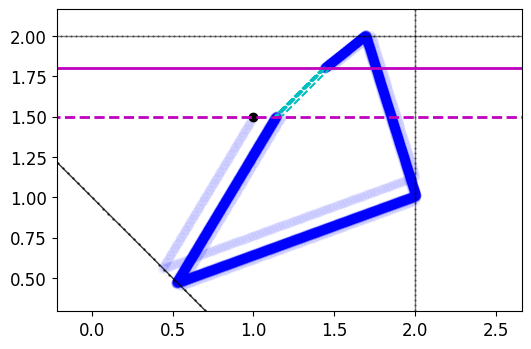

In [232]:
# Simulating the trajectory from an initial position

cmin = 1.0
#cmin = 1.0
smax = 2.0
mmax = 2.0
me = 1.8
rates = {'s':[-0.3,-0.25,2.2],
        'm':[-0.5,-0.2,0.8]}

initial_state = (0,0)
x0 = np.array([1,1.5])
step = 0.01

trigger_state_names = ['elimination','decay','synthesis']
state_vectors = {}
for i in range(3):
    for j in range(3):
        state_vectors[(i,j)] = [rates['s'][i],rates['m'][j]]
        state_vectors[(i,j)] /=np.linalg.norm(state_vectors[(i,j)])


cc_automaton = define_SG2M_model_2D(cmin=cmin,smax=smax,mmax=mmax,me=me,state_vectors=state_vectors)

cc_automaton['x'] = x0
cc_automaton['state'] = initial_state

points = simulate_the_model_2D(cc_automaton,x0=x0,initial_state=initial_state)

plt.savefig(dataset_name+'_switch_linear.png')
plt.show()